In [1]:
from IPython.display import display,HTML
def dhtml(str):
    display(HTML("""<style>
    @import 'https://fonts.googleapis.com/css?family=Akronim|Smokum&effect=3d';      
    </style><h1 class='font-effect-3d' 
    style='font-family:Akronim; color:#ff3311; font-size:35px;'>
    %s</h1>"""%str))
style_dict={'background-color':'silver','color':'#ff3311',
            'font-size':'15px','font-family':'Smokum'}

In [2]:
dhtml('Code Modules')

In [3]:
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-0rxq3axi
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-0rxq3axi
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0fb9009c3d4e2befd0500d05a139a63a94a067772_-py3-none-any.whl size=126412 sha256=7081a630975564a3af44389b9638a525c8d50e1d184d2b39972f5d213b8f1760
  Stored in directory: /tmp/pip-ephem-wheel-cache-1kp6ew77/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [4]:
import warnings; warnings.filterwarnings('ignore')
import pandas as pd,numpy as np,tensorflow as tf
import h5py,imageio,os,torch
import seaborn as sn,pylab as pl
from tensorflow.keras.preprocessing import image as kimage
from tensorflow_docs.vis import embed
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from skimage import io
from io import BytesIO
from ipywidgets import widgets
from tqdm import tqdm
from PIL import ImageFile,Image
from torch.utils.data import DataLoader as tdl
from torch.utils.data import Dataset as tds
from torchvision import transforms,utils
from IPython.core.magic import register_line_magic
ImageFile.LOAD_TRUNCATED_IMAGES=True
dev=torch.device("cuda:0" \
if torch.cuda.is_available() else "cpu")

In [5]:
dhtml('Data Processing')

In [6]:
def path_to_tensor(img_path,fpath):
    img=kimage.load_img(fpath+img_path,grayscale=True, 
                        target_size=(img_size,img_size))
    x=kimage.img_to_array(img)
    return np.expand_dims(x,axis=0)
def paths_to_tensor(img_paths,fpath):
    tensor_list=[path_to_tensor(img_path,fpath) 
                 for img_path in tqdm(img_paths)]
    return np.vstack(tensor_list)

In [7]:
img_size=64
manners=['pictogram','contour','sketch']
objects=['flower','bird','butterfly','tree',
         'airplane','crane','dog','horse']
fpath='../input/art-pictogram/'
flist=sorted(os.listdir(fpath))
labels1=np.array([int(el[:2]) for el in flist],
                 dtype='int8')-1
labels2=np.array([int(el[3:6]) for el in flist],
                 dtype='int8')-1
images=np.array(paths_to_tensor(flist,fpath=fpath),
                dtype='float32')/255
N=labels1.shape[0]; n=int(.2*N)
shuffle_ids=np.arange(N)
np.random.RandomState(12).shuffle(shuffle_ids)
images,labels1,labels2=images[shuffle_ids],\
labels1[shuffle_ids],labels2[shuffle_ids]
x_test,x_train=images[:n],images[n:]
y_test1,y_train1=labels1[:n],labels1[n:]
y_test2,y_train2=labels2[:n],labels2[n:]

100%|██████████| 693/693 [00:01<00:00, 602.56it/s]


In [8]:
pd.DataFrame([[x_train.shape,x_test.shape],
              [x_train.dtype,x_test.dtype],
              [y_train1.shape,y_test1.shape],
              [y_train1.dtype,y_test1.dtype],
              [y_train2.shape,y_test2.shape],
              [y_train2.dtype,y_test2.dtype]],               
             columns=['train','test'])\
.style.set_properties(**style_dict)

,train,test
0,"(555, 64, 64, 1)","(138, 64, 64, 1)"
1,float32,float32
2,"(555,)","(138,)"
3,int8,int8
4,"(555,)","(138,)"
5,int8,int8


In [9]:
with h5py.File('ArtPictogramImages.h5','w') as f:
    f.create_dataset('train_images',data=x_train)
    f.create_dataset('train_labels1',data=y_train1)
    f.create_dataset('train_labels2',data=y_train2)
    f.create_dataset('test_images',data=x_test)
    f.create_dataset('test_labels1',data=y_test1)
    f.create_dataset('test_labels2',data=y_test2)
os.stat('ArtPictogramImages.h5')

os.stat_result(st_mode=33188, st_ino=131083, st_dev=1793, st_nlink=1, st_uid=0, st_gid=0, st_size=11360256, st_atime=1596132423, st_mtime=1596132423, st_ctime=1596132423)

In [10]:
train_csv='train.csv'
valid_csv='valid_csv'; test_csv='test.csv'
img_path='../input'; img_size2=32
files=[os.path.relpath(os.path.join(dirpath,fn),img_path) \
for (dirpath,dirnames,filenames) in os.walk(img_path) \
for fn in filenames if fn.endswith('.png')]
d={'label1':[],'manner':[],'label2':[],
   'object':[],'file':[],'path':[]}
for f in files:
    _,fn=f.split('/')
    label1=int(fn[:2])-1; label2=int(fn[3:6])-1
    manner=manners[label1]; obj=objects[label2]        
    d['label1'].append(label1); d['manner'].append(manner)
    d['label2'].append(label2); d['object'].append(obj)
    d['file'].append(fn); d['path'].append(f)
df=pd.DataFrame.from_dict(d)
np.random.seed(123)
ids=np.random.rand(len(df))<.8
df_train=df[ids]; df_test=df[~ids]
df_train.set_index('file',inplace=True)
df_train.to_csv(train_csv)
df_test.set_index('file',inplace=True)
df_test[:df_test.shape[0]//2].to_csv(test_csv)
df_test[df_test.shape[0]//2:].to_csv(valid_csv)
num_classes1=np.unique(df['label1'].values).shape[0]
num_classes2=np.unique(df['label2'].values).shape[0]
print([num_classes1,num_classes2,len(files)])
df_test.tail(3).T.style.set_properties(**style_dict)

[3, 8, 693]


file,01_005_00017.png,01_002_00041.png,01_004_00059.png
label1,0,0,0
manner,pictogram,pictogram,pictogram
label2,4,1,3
object,airplane,bird,tree
path,art-pictogram/01_005_00017.png,art-pictogram/01_002_00041.png,art-pictogram/01_004_00059.png


In [11]:
class PicsData(tds):
    def __init__(self,csv_path,img_dir,transform=None):
        df=pd.read_csv(csv_path,index_col=0)
        self.img_dir=img_dir
        self.csv_path=csv_path
        self.img_paths=df['path']
        self.y=df['label2'].values
        self.transform=transform
    def __getitem__(self,index):
        img=Image.open(os.path\
        .join(self.img_dir,self.img_paths[index]))
        img=img.convert('RGB')
        if self.transform is not None:
            img=self.transform(img)
        lbl=self.y[index]
        return img,lbl
    def __len__(self):
        return self.y.shape[0]

In [12]:
batch_size=16; num_workers=4; grayscale=True
trans=transforms\
.Compose([transforms.Resize((img_size2,img_size2)),
          transforms.Grayscale(num_output_channels=1),
          transforms.ToTensor()])
train=PicsData(csv_path=train_csv,
               img_dir=img_path,
               transform=trans)
test=PicsData(csv_path=test_csv,
              img_dir=img_path,
              transform=trans)
valid=PicsData(csv_path=valid_csv,
               img_dir=img_path,
               transform=trans)
dataloaders={'train':tdl(dataset=train,batch_size=batch_size,
                         shuffle=True,num_workers=num_workers),
             'test':tdl(dataset=test,batch_size=batch_size,
                        shuffle=True,num_workers=num_workers),
             'valid':tdl(dataset=valid,batch_size=batch_size,
                         shuffle=True,num_workers=num_workers)}

In [13]:
dhtml('Data Representation')

In [14]:
set(labels1),set(labels2)

({0, 1, 2}, {0, 1, 2, 3, 4, 5, 6, 7})

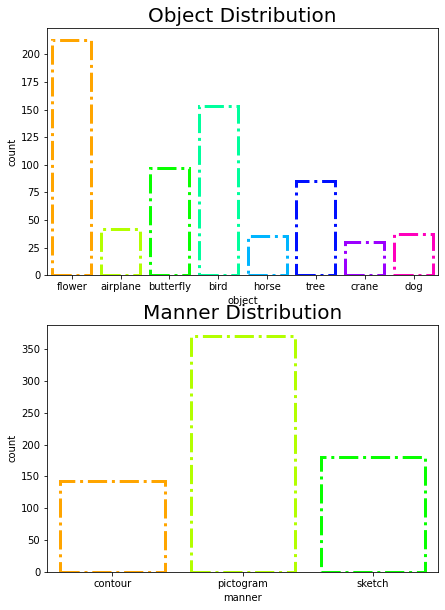

In [15]:
pl.figure(figsize=(7,10))
pl.subplot(211)
sn.countplot(x='object',data=df,
             facecolor='none',linewidth=3,linestyle='-.',
             edgecolor=sn.color_palette('hsv',8))
pl.title('Object Distribution',fontsize=20)
pl.subplot(212)
sn.countplot(x='manner',data=df,
             facecolor='none',linewidth=3,linestyle='-.',
             edgecolor=sn.color_palette('hsv',8))
pl.title('Manner Distribution',fontsize=20);

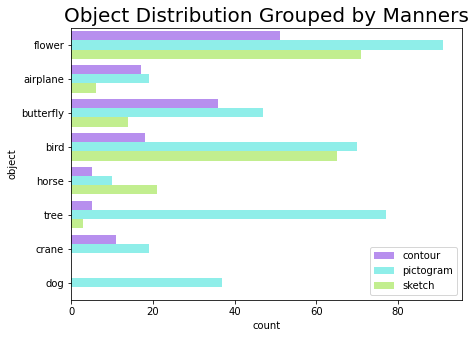

In [16]:
pl.figure(figsize=(7,5))
sn.countplot(y='object',hue='manner', 
             data=df,palette='hsv_r',alpha=.5)
ti='Object Distribution Grouped by Manners'
pl.title(ti,fontsize=20); pl.legend(loc=4);

In [17]:
@register_line_magic
def display_examples(data):
    for images,labels in dataloaders[data]:  
        print('Image dimensions: %s'%str(images.shape))
        print('Label dimensions: %s'%str(labels.shape))
        n=np.random.randint(1,3)
        fig=pl.figure(figsize=(7,2))
        for i in range(n,n+5):
            ax=fig.add_subplot(1,5,i-n+1,\
            xticks=[],yticks=[],\
            title=objects[labels[i].item()])
            ax.imshow(np.transpose(images[i],(1,2,0))\
                     .reshape(img_size2,img_size2),
                      cmap='bone')
        break

Image dimensions: torch.Size([16, 1, 32, 32])
Label dimensions: torch.Size([16])


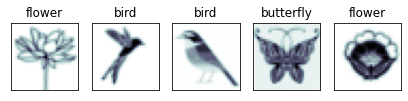

In [18]:
%display_examples valid

In [19]:
fig=make_subplots(1,5); steps=[]
for step in np.arange(1,6,1):
    img=io.imread(fpath+'03_002_000%s.png'%(step+20))[:,:,:3]
    fig.add_trace(go.Image(z=img),1,int(step))
    fig.data[step-1].visible=False
fig.data[0].visible=True
for i in range(len(fig.data)):
    step=dict(method="update",
              args=[{"visible":[False]*len(fig.data)}])
    step["args"][0]["visible"][i]=True
    steps.append(step)
sliders=[dict(active=0,pad={"t":5},steps=steps)]
fig.update_layout(
    width=600,height=300,sliders=sliders,
    template='plotly_dark',
    title_text="Bird Pictograms",title_font=dict(size=15))
fig.update_xaxes(showticklabels=False)\
   .update_yaxes(showticklabels=False)
fig.show()

In [20]:
def animate(images):
    converted_images=np.clip(images*255,0,255)\
    .astype(np.uint8)
    imageio.mimsave('animation.gif',converted_images)
    return embed.embed_file('animation.gif')
def interpolate_hypersphere(v1,v2,steps):
    v1norm=tf.norm(v1)
    v2norm=tf.norm(v2)
    v2normalized=v2*(v1norm/v2norm)
    vectors=[]
    for step in range(steps):
        interpolated=v1+(v2normalized-v1)*step/(steps-1)
        interpolated_norm=tf.norm(interpolated)
        interpolated_normalized=\
        interpolated*(v1norm/interpolated_norm)
        vectors.append(interpolated_normalized)
    return tf.stack(vectors)


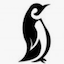

In [21]:
imgs=interpolate_hypersphere(x_train[0],x_train[1],240)
animate(imgs)